In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [929]:
def build_circle_image(size=[64,128], offset=[0,0], radius=15,
                       fg_color=[1.,0.,0.], bg_color=[0.,0.,1.], to_int=True):
    H,W = size
    center = (np.array(size) // 2) + np.array(offset)
    def _in_circle(y,x):
        r = np.sqrt((y - center[0])**2 + (x - center[1])**2)
        return r < float(radius)
    
    ones = np.ones((H,W), dtype=np.float32)
    him = np.arange(H)[:,None] * ones
    wim = np.arange(W)[None,:] * ones
    labels = _in_circle(him,wim).astype(np.uint8)
    image = np.ones(size + [3], dtype=np.float32) * np.array(bg_color).reshape((1,1,3))
    image[np.where(labels > 0.5)] = fg_color
    if to_int:
        image = (image * 255.).astype(np.uint8)
    return image, labels

def build_toy_inputs(size=[512,1024], batch_size=1, param_dicts=None):
    
    ims = []
    labs = []
    if param_dicts is None:
        param_dicts = [{} for _ in range(batch_size)]
    for b in range(batch_size):
        im, lab = build_circle_image(size, to_int=True, **param_dicts[b])
        ims.append(im)
        labs.append(lab)
        
    ims = np.stack(ims, 0)
    labs = np.stack(labs, 0)
    
    inputs = {
        'images': ims.astype(np.float32),
        'objects': labs,
        'semantics': labs
    }
    
    return inputs

    

<IPython.core.display.Javascript object>


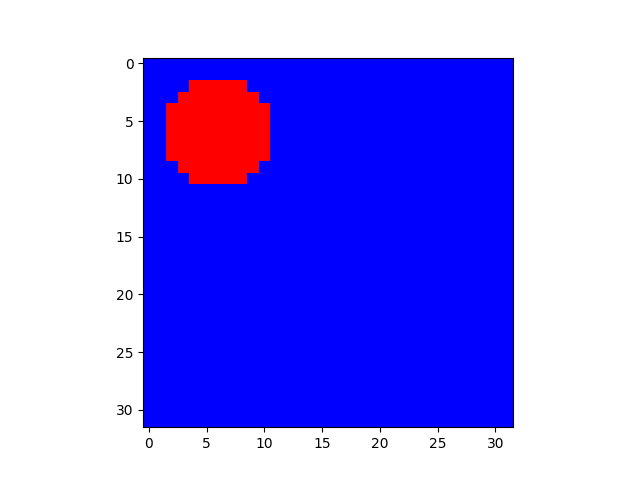

In [792]:
b = 1
# h,w = [64,64]
# inp = build_toy_inputs(size=[h,w], batch_size=b, param_dicts=[{'radius':15}])
# inp2 = build_toy_inputs(size=[h,w], batch_size=b, param_dicts=[{'radius':30, 'offset':[10,10]}])
# inp3 = build_toy_inputs(size=[h,w], batch_size=b, param_dicts=[{'radius': 10, 'offset': [-20,-20]}])
# plt.imshow(inp3['images'][0] / 255.)
# plt.show()

h,w = [32,32]
inp = build_toy_inputs(size=[h,w], batch_size=b, param_dicts=[{'radius':7}])
inp2 = build_toy_inputs(size=[h,w], batch_size=b, param_dicts=[{'radius':16, 'offset':[5,5]}])
inp3 = build_toy_inputs(size=[h,w], batch_size=b, param_dicts=[{'radius': 5, 'offset': [-10,-10]}])
plt.imshow(inp3['images'][0] / 255.)
plt.show()

<IPython.core.display.Javascript object>


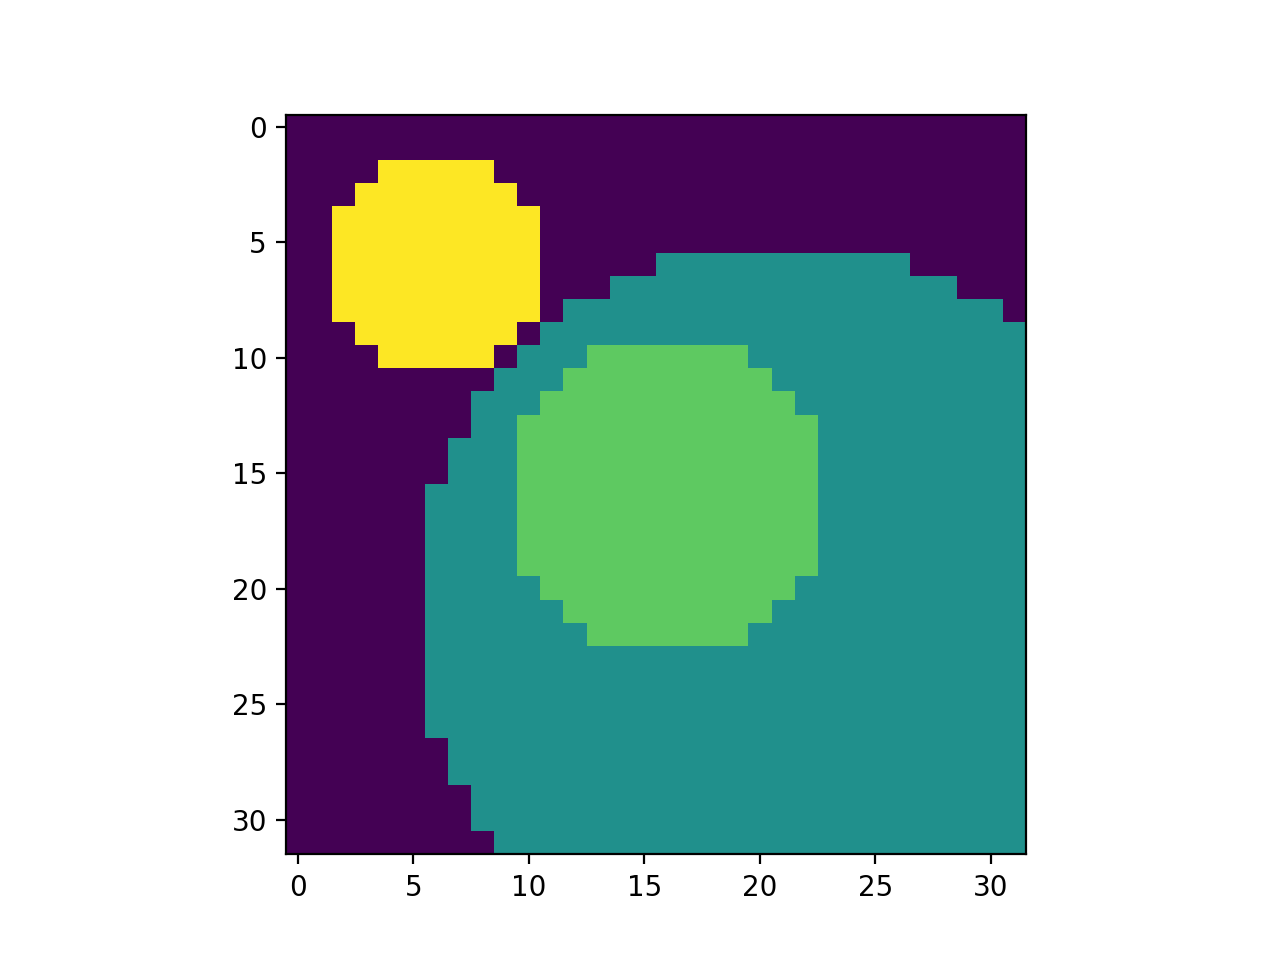

In [967]:
def softmax(x, beta=1.0, axis=-1):
    probs = np.exp(beta * (x - np.max(x, axis=axis, keepdims=True)))
    denom = np.sum(probs, axis=axis, keepdims=True)
    return probs / denom

def sigmoid(x, beta=1.0):
    y = np.exp(-1. * beta * x)
    return (1. / (1. + y))

def normalize_pos(x, axis=-1, eps=1e-8):
    x = np.maximum(x, 0.)
    norm = np.sqrt(np.sum(x**2, axis=axis, keepdims=True))
    return x / (norm + eps)

def get_local_kernel_mask(size=[64,64], k=5):
    _h,_w = size
    him = np.tile(np.arange(_h)[:,None], [1,_w])
    wim = np.tile(np.arange(_w)[None], [_h,1])
    x = np.stack([him,wim], -1) # [_h,_w,2]
    mask = x[:,:,None,None] - x[None,None,:,:]
#     mask = (np.square(mask) < k**2).astype(np.float32)
#     mask = mask[...,0] * mask[...,1]
    mask = np.sqrt(np.sum(mask**2, -1)) < k
    return np.reshape(mask, (_h*_w, _h*_w))


obj = inp['objects'] + 2 * inp2['objects'] + 4 * inp3['objects']
adj = obj.reshape((b,-1))
adj = (adj[...,None] == adj[:,None]).astype(np.float32)
mask = get_local_kernel_mask([h,w], k=7)[None]
adj_e = adj * mask
adj_i = (1. - adj_e) * mask
adj_e2 = np.matmul(adj_e, adj_e)
adj_ei = np.matmul(adj_e, adj_i)
adj_ie = np.matmul(adj_i, adj_e)
u,s,vh = np.linalg.svd(adj_e)

N = adj_e.shape[1]

plt.imshow(obj[0])
plt.show()

In [1014]:
from tqdm import tqdm

Q = 8
beta = 100.0
seed = 2
num_iters = 30
excite = True
inhibit = True
push = True
smooth = True
damp = True

active_init = False
svd_init = False
lp_init = False
hard_lp = False

if hard_lp:
    assert excite

rng = np.random.RandomState(seed)
n0 = rng.choice(N)
if active_init:
    activated = np.ones([b,N,1], dtype=np.float32)
else:
    activated = np.zeros([b,N,1], dtype=np.float32)
    activated[:,n0,:] = 1.0
act = activated

if lp_init:
    Q = N
    x = np.eye(N)[None].astype(np.float32)
    perm = rng.permutation(N)
    x[:,range(N),:] = x[:,perm,:]
elif svd_init:
    x = u[...,:Q]
    x = normalize_pos(x)
else:
    x = np.random.uniform(size=[b,N,Q]).astype(np.float32)
    x = softmax(x, beta=beta, axis=-1)
    x[:,n0] = (0 == np.arange(Q)).astype(np.float32)

xs = [x + 0.]

avg = np.sum(x * activated, axis=1, keepdims=True) / np.sum(activated, axis=1, keepdims=True)
avgs = [avg + 0.]
es = [softmax(1. - avg, beta, axis=-1)]
acts = [act + 0.]

for it in tqdm(range(num_iters)):
    n_senders_e = np.maximum(1., np.sum(adj_e * act, axis=-2, keepdims=True)) # [B,1,N]
    n_senders_i = np.maximum(1., np.sum(adj_i * act, axis=-2, keepdims=True)) # [B,1,N]
    
    if excite:
        e_effects = np.matmul(x.transpose(0,2,1), adj_e * act) / n_senders_e
        x += e_effects.transpose(0,2,1)
    
    if inhibit:
        dots = np.matmul(x, x.transpose(0,2,1)) # [b,N,N]
        i_effects = np.matmul(x.transpose(0,2,1), adj_i * act) / n_senders_i
        x -= i_effects.transpose(0,2,1)
                
    if hard_lp:
        x = np.argmax(e_effects, axis=-1)
        x = (x[...,None] == np.arange(Q)[None,None,:]).astype(np.float32)
    else:
        x = normalize_pos(x)
    receivers = np.max(np.maximum(adj_e,adj_i) * act, axis=1, keepdims=False)
    activated[np.where(receivers)] += 1.0
    act = np.minimum(1., activated)
    avg = np.sum(softmax(x, beta, -1) * act, axis=1, keepdims=True) / np.sum(act, axis=1, keepdims=True)    
#     
    if push:
        e = softmax(1. - avg, beta=beta, axis=-1)
#         p_effects = np.sum(adj_i * act, axis=1, keepdims=True) / n_senders_i # [B,1,N]
#         p_effects = np.sum(adj_i * act, axis=1, keepdims=True) # [B,1,N]
#         p_effects = n_senders_i
        p_effects = n_senders_i * act.transpose(0,2,1)
        p_effects = p_effects * ((1. - act) * e).transpose(0,2,1)
        es.append(e + 0.)
        x += p_effects.transpose(0,2,1) 
        x = normalize_pos(x)
    
    # smooth by double excitation path among all neurons?
    if smooth:
        s_effects = act * adj_e2 * act.transpose(0,2,1) # [B,S,R] == [B,N,N]
        s_effects = np.matmul(x.transpose(0,2,1), s_effects) / (n_senders_e**2) # [B,Q,N]
        x += s_effects.transpose(0,2,1)    
        
#         s_effects = act * adj_ie * act.transpose(0,2,1)
#         s_effects = np.matmul(x.transpose(0,2,1), s_effects) / (n_senders_e * n_senders_i)
#         x -= s_effects.transpose(0,2,1)
        
        x = normalize_pos(x)     
        
#     receivers = np.max(np.maximum(adj_e,adj_i) * activated, axis=1, keepdims=False)
#     activated[np.where(receivers)] += 1.0
#     act = np.minimum(1., activated)
#     avg = np.sum(x * act, axis=1, keepdims=True) / np.sum(act, axis=1, keepdims=True)  

#     avg = softmax(np.sum(x * act , axis=1, keepdims=True) / np.sum(act, axis=1, keepdims=True), beta=50., axis=-1)
    
    if damp:
        x += (1. - avg) * sigmoid(-activated)
        x = normalize_pos(x)
    
    xs.append(x + 0.)
    avgs.append(avg + 0.)
    
plateau = np.reshape(xs[-1], (b,h,w,Q))

# plt.imshow(np.argmax(plateau[0], -1))
# plt.colorbar()
# plt.show()

100%|██████████| 30/30 [00:00<00:00, 40.35it/s]


<IPython.core.display.Javascript object>


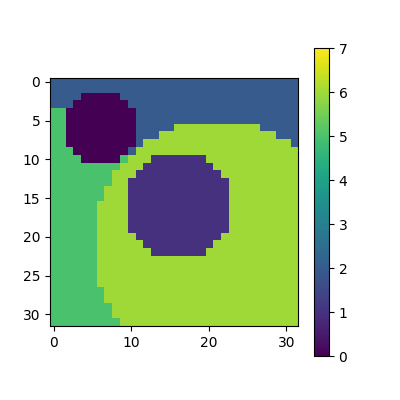

In [1016]:
%matplotlib nbagg
SAVE = False

def get_frame(xs, idx=0, b=0):
    fr = xs[idx][b].reshape((h,w,-1))
    fr = np.argmax(fr, axis=-1)
    return fr

idx = 0

fig, axes = plt.subplots(figsize=(4,4))
im = plt.imshow(get_frame(xs, idx, 0), origin='upper')

def animate(*args):
    global idx
    
    fr = get_frame(xs, idx)
    im.set_array(fr)
    idx += 1
    idx %= len(xs)
    
    return im,

def savegif(ani, directory, file):
    import os
    f = os.path.join(directory, file.split('.')[0]) + ".gif"
    writergif = animation.PillowWriter(fps=10)
    ani.save(f, writer=writergif)

ani = animation.FuncAnimation(fig, animate, interval=400)
plt.colorbar()
plt.show()

if SAVE:
    savegif(ani, '/Users/db/neuroailab/kaleidoscope', 'kaleid2.gif')

<IPython.core.display.Javascript object>


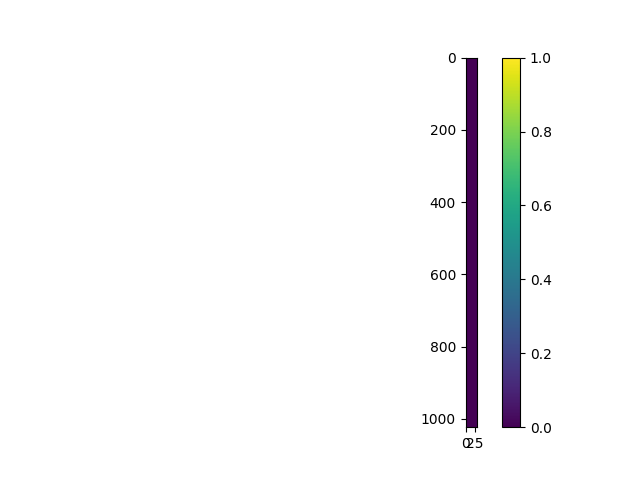

In [988]:
i,j = [5,5]
plt.imshow(np.stack([x.reshape(h,w,Q)[i,j] for x in xs], -1))
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


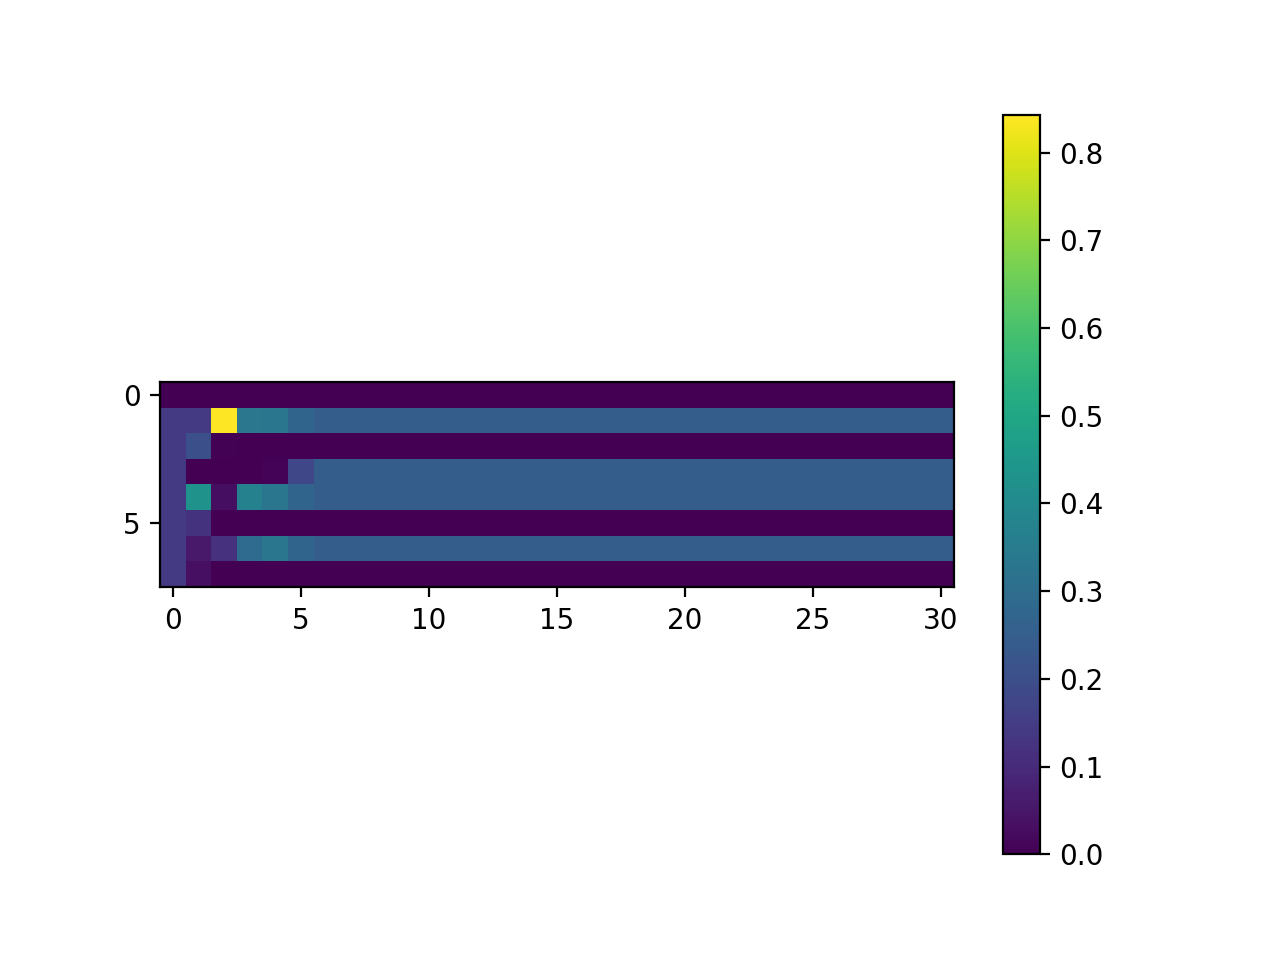

In [954]:
plt.imshow(np.stack([a[0,0,:] for a in es], -1))
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


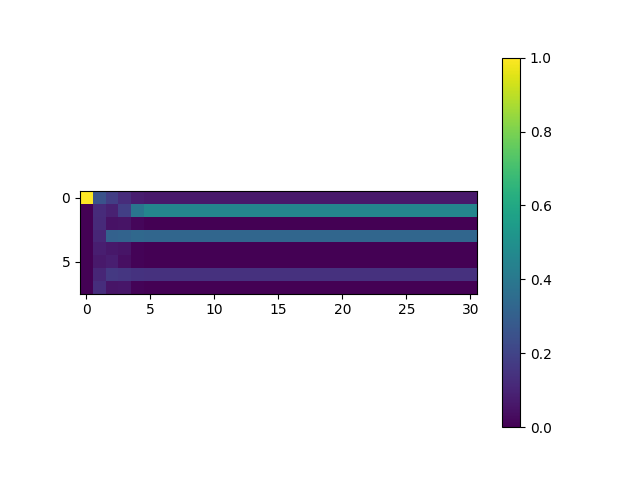

In [831]:
plt.imshow(np.stack([a[0,0,:] for a in avgs], -1))
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


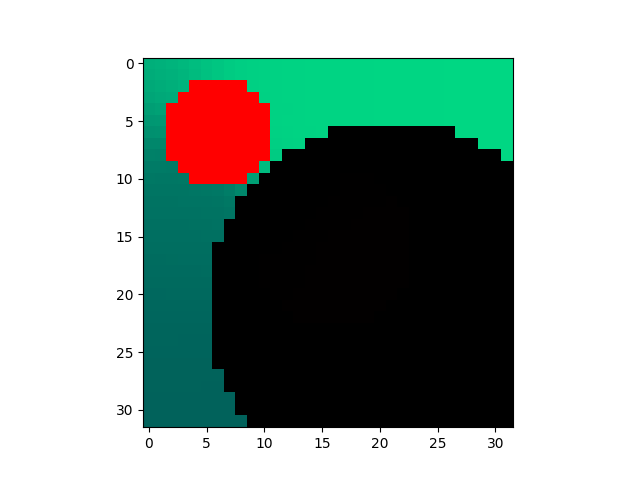

In [1032]:
cs = [0,2,4]
pl = np.stack([plateau[0,...,c] for c in cs], -1)
plt.imshow(pl)
plt.show()

<IPython.core.display.Javascript object>


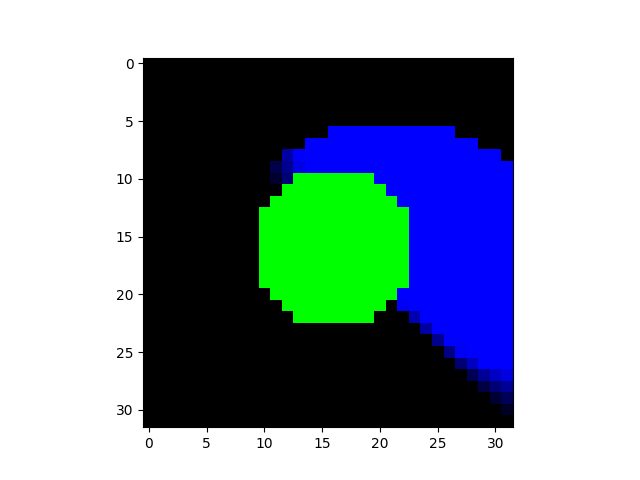

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [933]:
plt.imshow((u[0,:,0:3].reshape((32,32,-1))) * 100.)
plt.show()

In [ ]:
### TODO: push effects 
### TODO: initizliation
### TODO: compare to hard and soft labelprop
### TODO: more complex images
### TODO: Tensorflow grnn

Trying to solve: 
(1) the memory problem of both hard and soft LP by propagating in fewer channels
(2) the memory and computational problem of using global affinities, which easily "skip" over boundaries b/w similar objects
(3) is end-to-end differentiable in only the affinities between nodes

Ideally, this would also address some of the explicanda about perceptual grouping from neurobiology:
(A) it's a process that takes time, likely due to recurrence; but 1-4 objects can be "subitized" in equal time
(B) For K > 4, increasing objects take linearly increasing time, up to a max of ~8
(C) It is sensitive to local cues and especially contours: if two figures are separated by a gap, they're diff objects
(D) But if two pieces look like they could be connected behind occlusion, they are -- though this seems to require longer-taking processes (perhaps due to feedback, longer paths through the network)
(E) Local spreading phenomena appear to begin near figure-ground boundaries
(F) overall process is sensitive to learned object templates, but objects without templates aren't invisible
(G) Multiple types of features can be used as input to the process, though some may dominate over others: motion, depth, shape, contour continuation, texture...

A Simple Neural Circuit
Keep the good parts of soft LP (differentiable, smoothing) but reintroduce the good parts of hard LP (orthogonalization) and make due with fewer possible nodes

Additions:
(1) besides "excitatory" smoothing of soft LP, add 
(2) inhibition between nodes that subtracts off values in each dimension
(3) a temporal activation spreading effect so that coalitions can only form in one place first
(3) a "kicking" or "pushing" effect that moves unactivated nodes into an unoccupied channel if possible
(4) initializations of (A) where to start spreading and (B) what channels various nodes are biased to be kicked into
(5) "skeleton" that grows over time to allow for more smoothing (via recurrent pathways or higher-level feature feedback)


Push effects should speed up convergence by exciting a particular label channel of a neuron not yet activated, but currently being inhibited

which label should be excited? the next one down the order from the pushing neurons?

or the one that's most common among its excitatory "skeleton" and also not the one from the pushing neurons?

Average map of excited neurons?

Check whether coalitions are really coalitions by looking at plateau map 

Make activated tensor be graded rather than binary to favor earlier/more amplified neurons?

let skeleton grow in scale over time due to "feedback"? 

Double inhibitory path should prevent mutually inhibiting nodes from pointing in the same direction -- have to be pushed somehow; break symmetry by giving a stronger push by some?

Break initial symmetry by making it easier to push distant nodes into the same dimensions (feedforward tickling)

As time goes on, longer paths (via feedback?) should become available betwen two nodes -- thus allowing for homogezation (e.g. across occlusions)

Multiplex code so run twice, then take tensor product of channels? 8 by 8 or 6 by 6 by 6 performed with different intiializations?

Use error map feedback to split groups with same label -- regions of high error should be "Loose" and movable

In [506]:
6 * 6 * 6

216

(array([[[0.        , 6.15600204, 5.39580309, 4.57645088, 3.72029305,
          2.85329515, 1.93036175, 0.9822765 ]]]),
 array([[[0.001165  , 0.54934183, 0.25685762, 0.11320153, 0.048087  ,
          0.02020669, 0.00802917, 0.00311116]]]))